# Rockley Bio-Sensor Selection Codesign Playground

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import seaborn as sns

In [ ]:
from sklearn.linear_model import LinearRegression

## Mount Google Drive and configure PYTHONPATH variable

**Before running:** Find the `optimized_bio_sensor` folder in Drive and use the `Add shortcut to Drive` option to add it to `MyDrive`

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
import os
# os.environ['PYTHONPATH'] += ':/content/gdrive/MyDrive/22FL/CS101-TA/optimized_bio_sensor/RockleyCodesign'
os.environ['PYTHONPATH'] += ':/content/gdrive/MyDrive/optimized_bio_sensor/RockleyCodesign'
# %cd /content/gdrive/MyDrive/22FL/CS101-TA/optimized_bio_sensor/RockleyCodesign
%cd /content/gdrive/MyDrive/optimized_bio_sensor/RockleyCodesign

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/.shortcut-targets-by-id/1EaHvULJYewcfEpQ7wlYgmG1eRbVcahUv/optimized_bio_sensor/RockleyCodesign


# Load Data

In [ ]:
df = pd.read_parquet("../data/train_regression.parquet")
data = df.to_numpy(dtype=np.float32)

X = data[:, :-1]
Y = data[:, -1]

print(np.shape(X), np.shape(Y))

(160000, 197) (160000,)


In [ ]:
test_df = pd.read_parquet("../data/test_regression.parquet")
testdata = test_df.to_numpy(dtype=np.float32)

X_test_ = data[:, :-1]
Y_test_ = data[:, -1]

print(np.shape(X_test_), np.shape(Y_test_))

(160000, 197) (160000,)


# Utility Functions for standardization, plotting, and scoring

In [ ]:
# Utility functions
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Plot predicted vs actual graph
def plot_pred_v_actual(Y_pred, Y_actual, text=""):
  plt.scatter(Y_actual, Y_pred, s=0.1, color='blue')

  xs = np.linspace(1, 200)
  plt.plot(xs, xs, color='red')

  plt.xlabel("Actual")
  plt.ylabel("Predicted")
  plt.title("Predicted vs. Actual Graph")
  plt.text(10, 200, text)
  plt.show()

# Plot residual graph
def plot_residual(Y_pred, Y_actual):
  Y_pred = Y_pred.reshape(-1)
  Y_actual = Y_actual.reshape(-1)
  residual = Y_actual - Y_pred
  plt.scatter(Y_actual, residual, alpha=0.5)
  plt.axhline(0, color="red")

  plt.xlabel("Actual")
  plt.ylabel("Residual of Actual - Predicted")
  plt.title("Predicted vs. Actual Residual Graph")
  plt.show()

def standardize(X_train, X_test, Y_train):
  X_mean = np.mean(X_train, axis=0)
  X_std = np.std(X_train, axis=0)

  X_train_norm = np.array(X_train)
  X_test_norm = np.array(X_test)
  for i in range(len(X_mean)):
    X_train_norm[:, i] = (X_train[:, i] - X_mean[i]) / X_std[i]
    X_test_norm[:, i] = (X_test[:, i] - X_mean[i]) / X_std[i]

  Y_mean = np.mean(Y_train)
  Y_std = np.std(Y_train)
  Y_train_norm = (Y_train - Y_mean) / Y_std

  return X_train_norm, X_test_norm, Y_train_norm

def destandardize(Y_train, Y_test):
  Y_mean = np.mean(Y_train)
  Y_std = np.std(Y_train)
  return Y_test * Y_std + Y_mean
def calc_percent_diff(Y_pred, Y_actual):
  percent_errors = []
  for i in range(len(Y_pred)):
    percent_errors.append(abs((Y_pred[i] - Y_actual[i]) / Y_actual[i]))
  return np.mean(percent_errors) * 100


# Data Preview

In [ ]:
display(df.describe().round(4))

scaler = StandardScaler()
standardized_df = scaler.fit_transform(df)
standardized_df = pd.DataFrame(standardized_df, columns=["Laser " + str(i) for i in range(1, 198)] + ['eEthanol'])
display(standardized_df.describe().round(4))

,Laser 1,Laser 2,Laser 3,Laser 4,Laser 5,Laser 6,Laser 7,Laser 8,Laser 9,Laser 10,...,Laser 189,Laser 190,Laser 191,Laser 192,Laser 193,Laser 194,Laser 195,Laser 196,Laser 197,eEthanol
count,160000.0000,160000.0000,160000.0000,160000.0000,160000.0000,160000.0000,160000.0000,160000.0000,160000.0000,160000.0000,...,160000.0000,160000.0000,160000.0000,160000.0000,160000.0000,160000.0000,160000.0000,160000.0000,160000.0000,160000.0000
mean,1.3522,1.5012,1.6543,1.7988,1.9166,2.0059,2.0708,2.1168,2.1498,2.1703,...,2.7806,2.8126,2.8468,2.8840,2.9065,2.9152,2.9313,2.9497,2.9730,100.0788
std,0.0356,0.0463,0.0583,0.0706,0.0812,0.0898,0.0963,0.1010,0.1044,0.1066,...,0.1886,0.1938,0.1995,0.2060,0.2099,0.2112,0.2141,0.2173,0.2216,57.7361
min,1.2410,1.3546,1.4659,1.5649,1.6442,1.7034,1.7464,1.7764,1.7958,1.8074,...,2.1696,2.1863,2.2042,2.2238,2.2340,2.2357,2.2424,2.2505,2.2613,0.0048
25%,1.3267,1.4682,1.6130,1.7490,1.8595,1.9430,2.0034,2.0461,2.0767,2.0957,...,2.6487,2.6771,2.7071,2.7396,2.7593,2.7670,2.7810,2.7970,2.8173,50.1235
50%,1.3507,1.4992,1.6519,1.7959,1.9134,2.0025,2.0671,2.1129,2.1460,2.1664,...,2.7730,2.8046,2.8386,2.8753,2.8975,2.9061,2.9221,2.9403,2.9633,100.0204
75%,1.3759,1.5319,1.6929,1.8454,1.9702,2.0650,2.1339,2.1829,2.2183,2.2401,...,2.9043,2.9395,2.9774,3.0188,3.0437,3.0535,3.0716,3.0920,3.1179,150.1159
max,1.5164,1.7193,1.9336,2.1406,2.3124,2.4442,2.5400,2.6075,2.6553,2.6838,...,3.7040,3.7604,3.8264,3.9024,3.9445,3.9535,3.9830,4.0182,4.0628,199.9985


,Laser 1,Laser 2,Laser 3,Laser 4,Laser 5,Laser 6,Laser 7,Laser 8,Laser 9,Laser 10,...,Laser 189,Laser 190,Laser 191,Laser 192,Laser 193,Laser 194,Laser 195,Laser 196,Laser 197,eEthanol
count,160000.0000,160000.0000,160000.0000,160000.0000,160000.0000,160000.0000,160000.0000,160000.0000,160000.0000,160000.0000,...,160000.0000,160000.0000,160000.0000,160000.0000,160000.0000,160000.0000,160000.0000,160000.0000,160000.0000,160000.0000
mean,-0.0000,-0.0000,-0.0000,0.0000,-0.0000,0.0000,0.0000,-0.0000,0.0000,-0.0000,...,-0.0000,-0.0000,0.0000,0.0000,-0.0000,-0.0000,-0.0000,-0.0000,0.0000,0.0000
std,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,...,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
min,-3.1260,-3.1659,-3.2318,-3.3146,-3.3534,-3.3686,-3.3701,-3.3709,-3.3903,-3.4042,...,-3.2400,-3.2314,-3.2201,-3.2055,-3.2044,-3.2164,-3.2184,-3.2172,-3.2120,-1.7333
25%,-0.7172,-0.7123,-0.7091,-0.7053,-0.7031,-0.7014,-0.7001,-0.7002,-0.6996,-0.6995,...,-0.6993,-0.6992,-0.6999,-0.7009,-0.7015,-0.7015,-0.7021,-0.7025,-0.7023,-0.8652
50%,-0.0439,-0.0427,-0.0412,-0.0408,-0.0398,-0.0387,-0.0382,-0.0379,-0.0367,-0.0366,...,-0.0403,-0.0410,-0.0412,-0.0420,-0.0427,-0.0430,-0.0430,-0.0434,-0.0438,-0.0010
75%,0.6645,0.6643,0.6617,0.6604,0.6597,0.6576,0.6562,0.6550,0.6558,0.6554,...,0.6557,0.6549,0.6547,0.6548,0.6539,0.6548,0.6553,0.6549,0.6542,0.8667
max,4.6116,4.7118,4.7900,4.8440,4.8711,4.8801,4.8751,4.8605,4.8407,4.8176,...,4.8961,4.8906,4.9097,4.9449,4.9464,4.9154,4.9131,4.9164,4.9185,1.7306


# Training Functions
Using K-Fold Validation and Training Test Split to train the data using linear regression.

In [ ]:
# Training functions

import sklearn
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

# Train with cross-validation
def train_with_CV(X, Y, model, metric, folds=5, norm=False, graph=True, **kwargs):
  metrics = []
  scores = []
  kf = KFold(n_splits=folds)
  for train_idx, test_idx in kf.split(X):
    x_train, y_train = X[train_idx], Y[train_idx]
    x_test, Y_test = X[test_idx], Y[test_idx]
    if norm:
      X_train, X_test, Y_train = standardize(x_train, x_test, y_train)
    else:
      X_train, X_test, Y_train = x_train, x_test, y_train

    reg = model(**kwargs)
    reg.fit(X_train, Y_train)

    Y_pred = reg.predict(X_test)
    if norm:
      Y_pred = destandardize(y_train, Y_pred)
    m = metric(Y_test, Y_pred)
    metrics.append(m)
    avg_metric = np.mean(metrics)
  
  # Take last fold and graph its result on test split and last seen regression
  if graph:
    plot_pred_v_actual(Y_pred, Y_test, "MSE=" + str(avg_metric.round(2)))
    plot_residual(Y_pred, Y_test)
  return avg_metric, reg

# Train just by splitting up the data into train/test
def train_with_split(X, Y, model, metric, split_size=0.2, norm=False, graph=True, **kwargs):
  x_train_split, x_test_split, y_train_split, Y_test_split = train_test_split(X, Y, test_size=0.2)
  if norm:
    X_train_split, X_test_split, Y_train_split = standardize(x_train_split, x_test_split, y_train_split)
  else:
    X_train_split, X_test_split, Y_train_split = x_train_split, x_test_split, y_train_split

  reg = model(**kwargs)
  reg.fit(X_train_split, Y_train_split)

  Y_pred = reg.predict(X_test_split)
  if norm:
      Y_pred = destandardize(y_train_split, Y_pred)
  if graph:
    plot_pred_v_actual(Y_pred, Y_test_split)
    plot_residual(Y_pred, Y_test_split)
  return metric(Y_test_split, Y_pred), reg

## Linear Regression
Error Metric using mean squared error

Without whitening

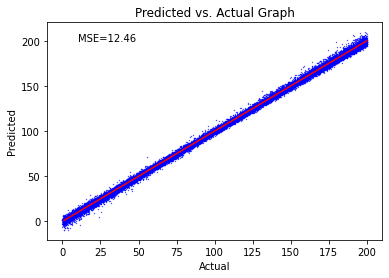

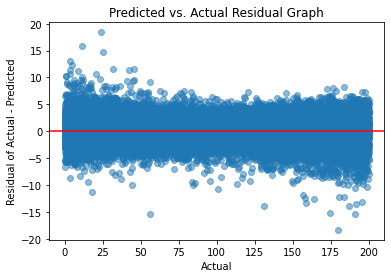

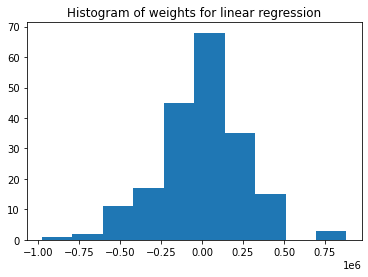

In [ ]:
from sklearn.linear_model import LinearRegression
metric, model = train_with_CV(X, Y, LinearRegression, metric=mean_squared_error, norm=False)

plt.hist(model.coef_)
plt.title("Histogram of weights for linear regression")
plt.show()


## With standardizing whitening

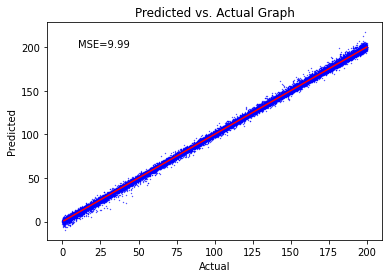

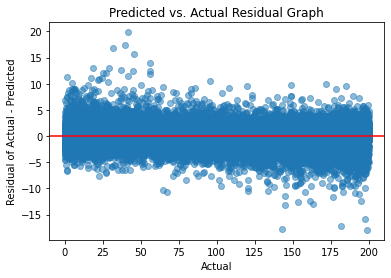

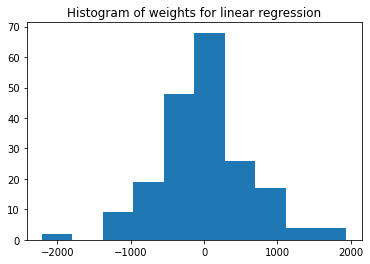

In [ ]:
metric, model = train_with_CV(X, Y, LinearRegression, metric=calc_percent_diff, norm=True)

plt.hist(model.coef_)
plt.title("Histogram of weights for linear regression")
plt.show()

## With normalizing

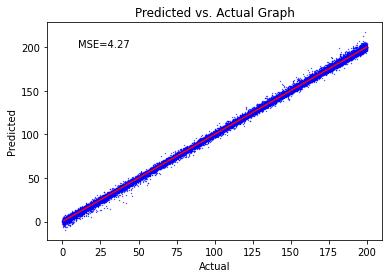

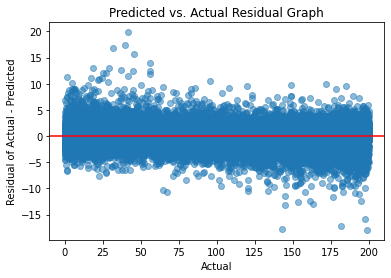

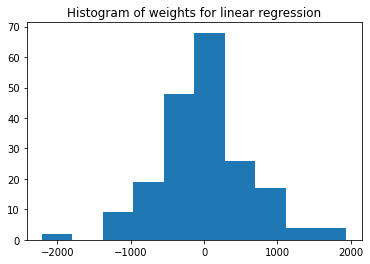

In [ ]:
metric, model = train_with_CV(X, Y, LinearRegression, metric=mean_squared_error, norm=True)

plt.hist(model.coef_)
plt.title("Histogram of weights for linear regression")
plt.show()

In [ ]:
def trainSubset(X, Y, removed, model, metric, **kwargs):
    remaining = [i for i in range(MAX_LASERS) if i not in removed]
    return train_with_CV(X[:, remaining], Y, model, metric, **kwargs)

## Generate Noisy float32 data

In [ ]:
order = -5
noisy_X_train_32_raw = np.random.normal(0, 10 ** order, X.shape) + X
noisy_X_train_32_norm = (noisy_X_train_32_raw - noisy_X_train_32_raw.mean(axis=0))/noisy_X_train_32_raw.std(axis=0)

noisy_X_test_32_raw = np.random.normal(0, 10 ** order, X_test_.shape) + X_test_
noisy_X_test_32_norm = (noisy_X_test_32_raw - noisy_X_test_32_raw.mean(axis=0))/noisy_X_test_32_raw.std(axis=0)

X_train_32_norm = (X - X.mean(axis=0))/X.std(axis=0)
X_test_32_norm = (X_test_ - X_test_.mean(axis=0)) / X.std(axis=0)

## Random Uniform float32 no-noise

In [ ]:
n_features = [20, 30, 40, 50, 60, 70]
ru_out_errors_32 = {}
for n in n_features:
  np.random.seed(2022)
  lasers = [i for i in range(197)]
  remaining = np.random.choice(lasers, n, replace=False)
  _, model = train_with_CV(X_train_32_norm[:, remaining], Y, LinearRegression, metric=mean_squared_error, norm=False, graph=False)

  y_pred = model.predict(X_test_32_norm[:, remaining])
  metric = mean_squared_error(Y_test_, y_pred)
  ru_out_errors_32[n] = metric

In [ ]:
ru_out_errors_32

{20: 1764.507,
 30: 17.715254,
 40: 13.269108,
 50: 16.1739,
 60: 5.8058977,
 70: 5.429694}

## Random Uniform float32 noisy

In [ ]:
n_features = [20, 30, 40, 50, 60, 70]
ru_out_errors_32_noisy = {}
for n in n_features:
  np.random.seed(2022)
  lasers = [i for i in range(197)]
  remaining = np.random.choice(lasers, n, replace=False)
  _, model = train_with_CV(noisy_X_train_32_norm[:, remaining], Y, LinearRegression, metric=mean_squared_error, norm=False, graph=False)

  y_pred = model.predict(noisy_X_test_32_norm[:, remaining])
  metric = mean_squared_error(Y_test_, y_pred)
  ru_out_errors_32_noisy[n] = metric

In [ ]:
ru_out_errors_32_noisy

{20: 1806.9304451611754,
 30: 145.53680483601278,
 40: 69.28542005152978,
 50: 63.403455396140096,
 60: 52.66896018769316,
 70: 51.69763914998368}

## Even-spaced float32 no noise

In [ ]:
n_features = [20, 30, 40, 50, 60, 70]
es_out_errors_32 = {}
for n in n_features:
  np.random.seed(2022)
  lasers = [i for i in range(197)]
  remaining = np.linspace(0, 196, n, dtype=int)
  _, model = train_with_CV(X_train_32_norm[:, remaining], Y, LinearRegression, metric=mean_squared_error, norm=False, graph=False)

  y_pred = model.predict(X_test_32_norm[:, remaining])
  metric = mean_squared_error(Y_test_, y_pred)
  es_out_errors_32[n] = metric

In [ ]:
es_out_errors_32

{20: 73.78996,
 30: 13.639333,
 40: 8.052972,
 50: 16.27244,
 60: 9.94224,
 70: 3.5471277}

## Even-spaced float32 noisy

In [ ]:
n_features = [20, 30, 40, 50, 60, 70]
es_out_errors_32_noisy = {}
for n in n_features:
  np.random.seed(2022)
  lasers = [i for i in range(197)]
  remaining = np.linspace(0, 196, n, dtype=int)
  _, model = train_with_CV(noisy_X_train_32_norm[:, remaining], Y, LinearRegression, metric=mean_squared_error, norm=False, graph=False)

  y_pred = model.predict(noisy_X_test_32_norm[:, remaining])
  metric = mean_squared_error(Y_test_, y_pred)
  es_out_errors_32_noisy[n] = metric

In [ ]:
es_out_errors_32_noisy

{20: 84.54751246858189,
 30: 75.60030178243356,
 40: 53.298558408984114,
 50: 48.12468909752115,
 60: 50.233304589986474,
 70: 42.62692183979215}

# Lasso Regression

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)
X_train, X_test, y_train = standardize(X_train, X_test, y_train)

# reg = Lasso(alpha=0, max_iter=30).fit(X_train, y_train)
# Y_pred = reg.predict(X_test) #Return the predictions
# Y_pred = destandardize(y_train, Y_pred)

# print(mean_squared_error(y_test, Y_pred))

reg = LinearRegression()
reg.fit(X_train, y_train)
Y_pred = reg.predict(X_test)
Y_pred = destandardize(y_train, Y_pred)

print(mean_squared_error(y_test, Y_pred))

# Note from Kevin: sklearn's linearregression also fails on your dataset

13255.233


In [ ]:
from sklearn.linear_model import Ridge

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)
X_train, X_test, y_train = standardize(X_train, X_test, y_train)

reg = Ridge(alpha=0.1).fit(X_train, y_train)
Y_pred = reg.predict(X_test) #Return the predictions
Y_pred = destandardize(y_train, Y_pred)

plt.hist(reg.coef_)
plt.title("Histogram of weights for linear regression")
plt.show()
plot_pred_v_actual(Y_pred, y_test)

mean_squared_error(y_test, Y_pred)


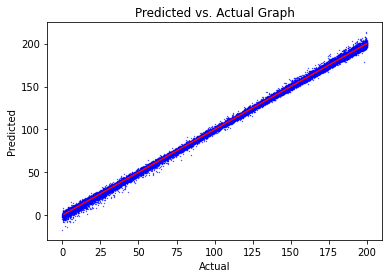

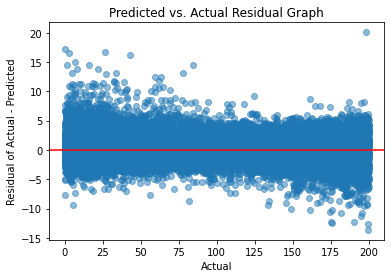

(4.495628, LinearRegression())

In [ ]:
train_with_split(X, Y, LinearRegression, mean_squared_error)

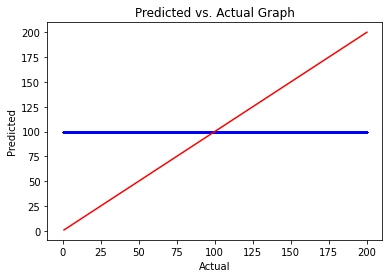

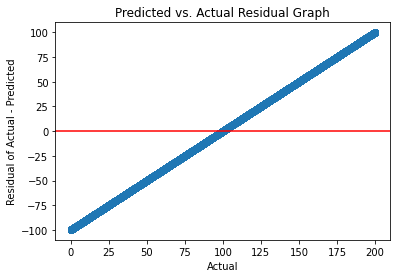

3333.057

In [ ]:
from sklearn.linear_model import Lasso
x_train, x_test, y_train, Y_test = train_test_split(X, Y, test_size=0.2)
X_train, X_test, Y_train = standardize(X_train, X_test, y_train)

reg = Lasso(alpha=0.1)
reg.fit(X_train, Y_train)

Y_pred = reg.predict(X_test)
Y_pred = destandardize(y_train, Y_pred)

plot_pred_v_actual(Y_pred, Y_test)
plot_residual(Y_pred, Y_test)
mean_squared_error(Y_test, Y_pred)

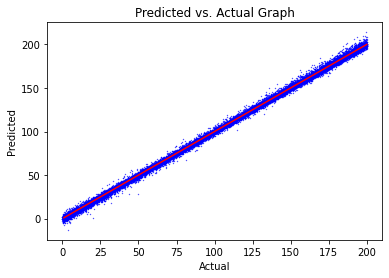

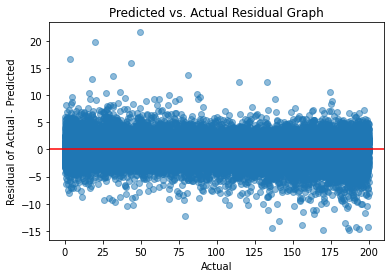

(4.074565, LinearRegression())

In [ ]:
train_with_split(X, Y, LinearRegression, mean_squared_error, norm=True)


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.006e+04, tolerance: 1.280e+01
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


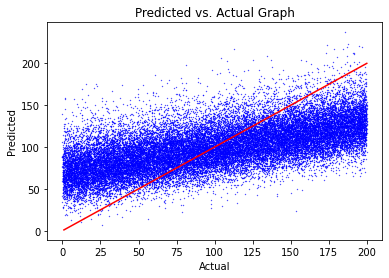

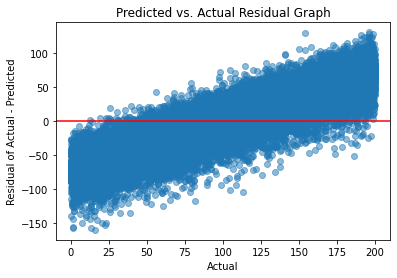

2090.7542
40.7059371471405


In [ ]:
from sklearn.linear_model import LassoCV

x_train_split, x_test_split, y_train_split, Y_test_split = train_test_split(X, Y, test_size=0.2)
X_train_split, X_test_split, Y_train_split = x_train_split, x_test_split, y_train_split
X_train_split, X_test_split, Y_train_split = standardize(X_train_split, X_test_split, Y_train_split)


reg = Lasso(alpha=1e-8, max_iter=10000)
reg.fit(X_train_split, Y_train_split)
Y_pred = reg.predict(X_test_split)
Y_pred = destandardize(y_train_split, Y_pred)

plot_pred_v_actual(Y_pred, Y_test_split)
plot_residual(Y_pred, Y_test_split)
print(mean_squared_error(Y_test_split, Y_pred))
print(calc_percent_diff(Y_test_split, Y_pred))


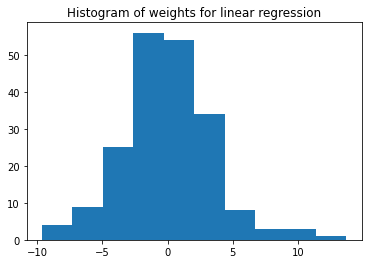

In [ ]:
plt.hist(reg.coef_)
plt.title("Histogram of weights for linear regression")
plt.show()

In [ ]:
reg.coef_

array([ 5.654519  , -6.062329  , -8.60771   , -5.0177155 , -4.663329  ,
       -0.9702738 ,  0.5250541 ,  1.6033688 ,  2.0188172 ,  1.37776   ,
        2.6882563 ,  2.8682766 ,  1.6703594 ,  0.9242252 ,  1.2060419 ,
       -0.5210634 , -1.0491891 , -1.1624488 , -0.37120777, -1.1986822 ,
       -2.5956953 , -1.8284314 , -1.4214797 , -2.6474571 , -0.03504227,
       -0.5944843 ,  0.09662405, -0.31478697,  0.04348733,  0.8261942 ,
        2.321223  ,  3.064748  ,  5.1987143 ,  5.9825616 ,  3.4611597 ,
        0.2534031 ,  0.53655666, -0.6675647 ,  1.0856569 ,  2.190245  ,
        0.28280154,  1.4821467 ,  1.6726055 ,  2.0958993 ,  2.33592   ,
        3.3828535 ,  1.3788528 ,  1.8364756 ,  2.034122  ,  0.15514056,
        1.4239882 ,  0.5274763 , -1.0074987 , -2.4204235 , -4.8435965 ,
       -7.319578  , -7.1644945 ,  2.5850654 ,  0.21268377, -8.462039  ,
        3.7134829 ,  4.42446   , -2.908421  ,  2.556931  ,  1.682659  ,
       -2.666745  , -5.5684557 ,  0.81896603,  1.665904  , -4.87

In [ ]:
X_train_split.shape

(128000, 197)

In [ ]:
contributing_coef = np.array(abs(reg.coef_) > 2.5, dtype=int)

[  0   1   2   3   4  10  11  20  23  31  32  33  34  45  54  55  56  57
  59  60  61  62  63  65  66  69  70  72  73  74  92  96  97  98  99 100
 102 103 104 105 111 112 113 114 115 116 117 130 131 132 133 134 141 142
 143 144 145 146 147 148 149 150 151 168 169 170 171 172 173 174 176 177
 178 180 181 183 190]


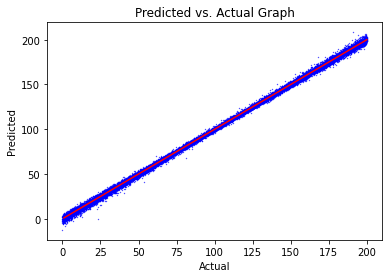

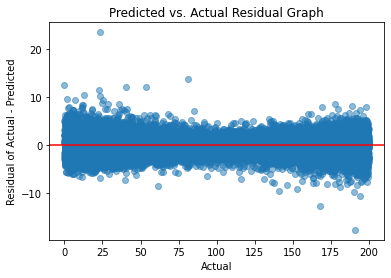

2.9710467
22.772470116615295


In [ ]:
idx = np.squeeze(np.nonzero(contributing_coef))
print(idx)
reg2 = LinearRegression()
reg2.fit(X_train_split[:, idx], Y_train_split)
Y_pred = reg2.predict(X_test_split[:, idx])
Y_pred = destandardize(y_train_split, Y_pred)

plot_pred_v_actual(Y_pred, Y_test_split)
plot_residual(Y_pred, Y_test_split)
print(mean_squared_error(Y_test_split, Y_pred))
print(calc_percent_diff(Y_test_split, Y_pred))

[  0   1   2   3   4  10  11  20  23  31  32  33  34  45  54  55  56  57
  59  60  61  62  63  65  66  69  70  72  73  74  92  96  97  98  99 100
 102 103 104 105 111 112 113 114 115 116 117 130 131 132 133 134 141 142
 143 144 145 146 147 148 149 150 151 168 169 170 171 172 173 174 176 177
 178 180 181 183 190]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.810e+04, tolerance: 1.280e+01
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


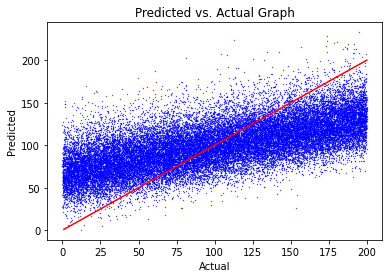

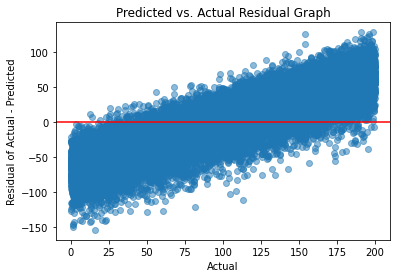

1987.24
40.01789391040802


In [ ]:

idx2 = np.squeeze(np.nonzero(contributing_coef))
print(idx)
reg2 = Lasso(alpha=1e-8, max_iter=10000)
reg2.fit(X_train_split[:, idx2], Y_train_split)
Y_pred = reg2.predict(X_test_split[:, idx2])
Y_pred = destandardize(y_train_split, Y_pred)

plot_pred_v_actual(Y_pred, Y_test_split)
plot_residual(Y_pred, Y_test_split)
print(mean_squared_error(Y_test_split, Y_pred))
print(calc_percent_diff(Y_test_split, Y_pred))

In [ ]:
len(idx2)

77

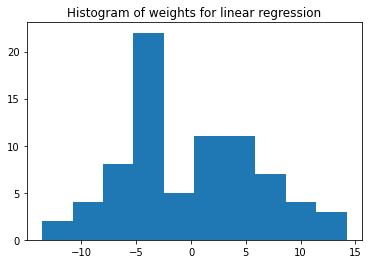

In [ ]:
plt.hist(reg2.coef_)
plt.title("Histogram of weights for linear regression")
plt.show()


In [ ]:
np.mean(np.abs(reg2.coef_))

5.215482

In [ ]:
contributing_coef2 = np.array(abs(reg2.coef_) > 2.5, dtype=int)


[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 15 16 18 19 20 21 24 26 27 28
 29 30 32 33 34 35 36 37 38 39 40 41 42 43 44 45 47 48 49 50 51 52 53 54
 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 71 72 73 74 76]


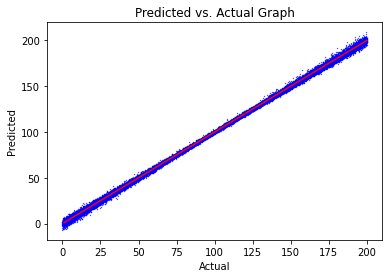

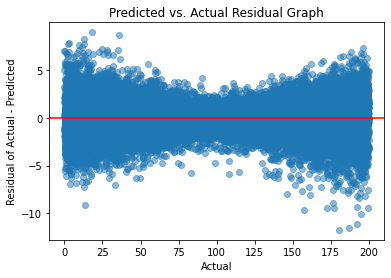

2.7033606
7.421355694532394


In [ ]:
idx3 = np.squeeze(np.nonzero(contributing_coef2))
print(idx3)
reg3 = LinearRegression()
reg3.fit(X_train_split[:, idx3], Y_train_split)
Y_pred = reg3.predict(X_test_split[:, idx3])
Y_pred = destandardize(y_train_split, Y_pred)

plot_pred_v_actual(Y_pred, Y_test_split)
plot_residual(Y_pred, Y_test_split)
print(mean_squared_error(Y_test_split, Y_pred))
print(calc_percent_diff(Y_test_split, Y_pred))

In [ ]:
len(idx3)


68

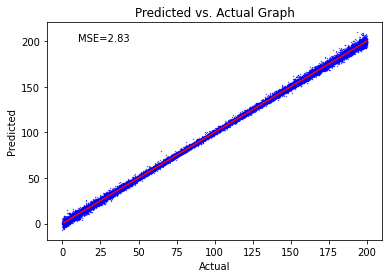

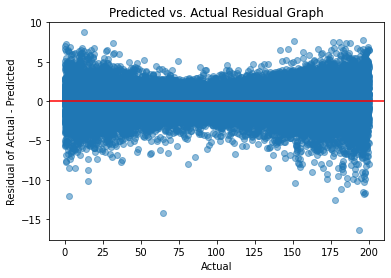

In [ ]:
res, model = train_with_CV(X[:, idx3], Y, LinearRegression, mean_squared_error, norm=True)

129742.66
77.98335552215576


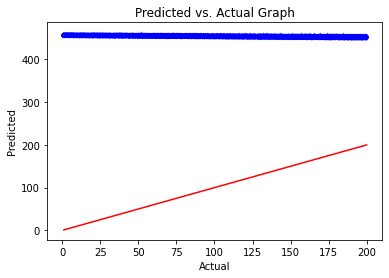

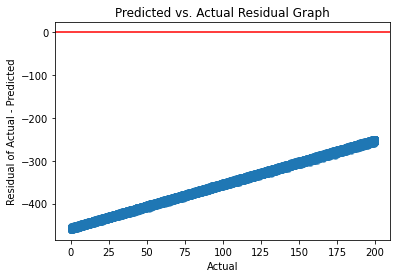

In [ ]:
test_df = pd.read_parquet("../data/test_regression.parquet")
testdata = test_df.to_numpy(dtype=np.float32)

X_test_ = data[:, :-1]
Y_test_ = data[:, -1]

Y_pred_ = model.predict(X_test_[:, idx3])
Y_pred_ = destandardize(y_train_split, Y_pred_)

print(mean_squared_error(Y_test_, Y_pred_))
print(calc_percent_diff(Y_test_, Y_pred_))
plot_pred_v_actual(Y_pred_, Y_test_)
plot_residual(Y_pred_, Y_test_)

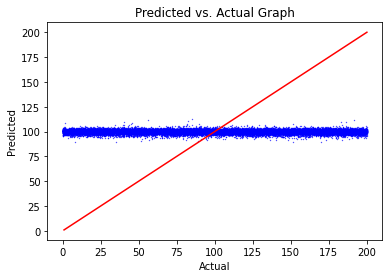

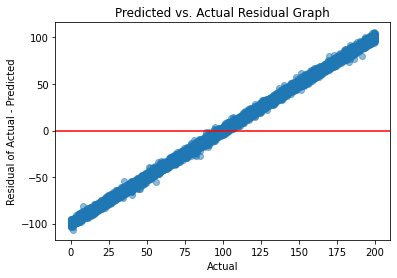

3330.8188

In [ ]:
from sklearn.linear_model import Ridge
x_train, x_test, y_train, Y_test = train_test_split(X, Y, test_size=0.2)
X_train, X_test, Y_train = standardize(X_train, X_test, y_train)

reg = LinearRegression()
reg.fit(X_train, Y_train)

Y_pred = reg.predict(X_test)
Y_pred = destandardize(y_train, Y_pred)

plot_pred_v_actual(Y_pred, Y_test)
plot_residual(Y_pred, Y_test)
mean_squared_error(Y_test, Y_pred)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.672e+04, tolerance: 1.280e+01
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.674e+04, tolerance: 1.280e+01
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisa

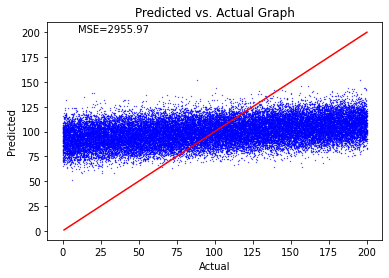

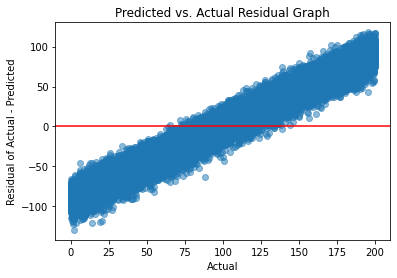

In [ ]:
res, model = train_with_CV(X[:, idx3], Y, Lasso, mean_squared_error, norm=True, alpha=1e-8, max_iter=10000)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=1.05618e-09): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=8.76653e-10): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=8.43255e-10): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=4.22849e-10): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-condit

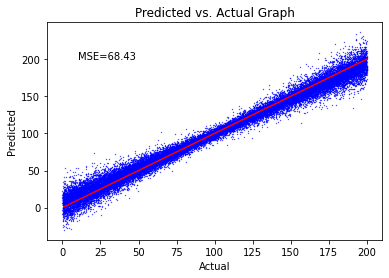

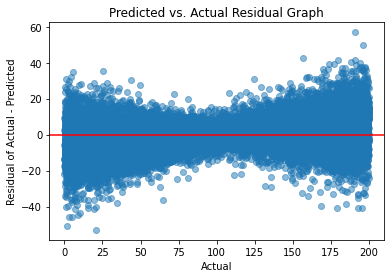

In [ ]:
res, model = train_with_CV(X, Y, Ridge, mean_squared_error, norm=True, alpha=1)

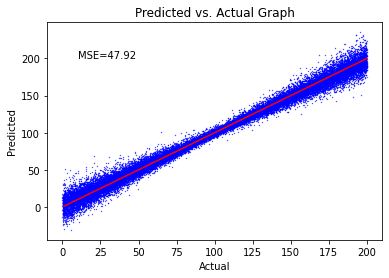

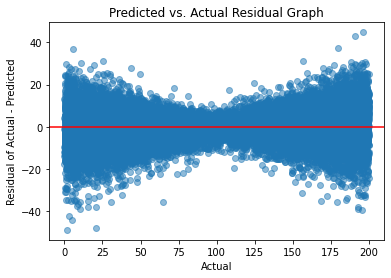

In [ ]:
res, model = train_with_CV(X, Y, Ridge, mean_squared_error, norm=True, alpha=0.1)

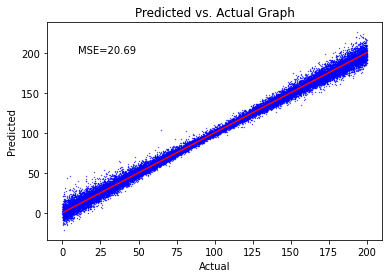

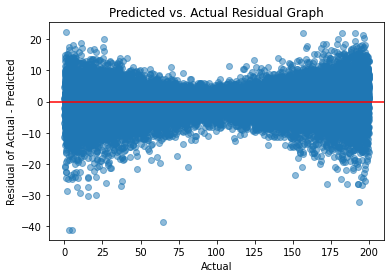

In [ ]:
res, model = train_with_CV(X, Y, Ridge, mean_squared_error, norm=True, alpha=0.01)

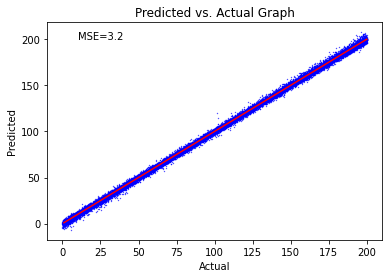

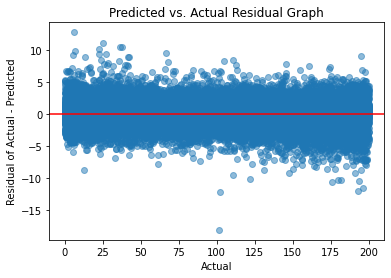

In [ ]:
res, model = train_with_CV(X[:], Y, Ridge, mean_squared_error, norm=True, alpha=1e-8)

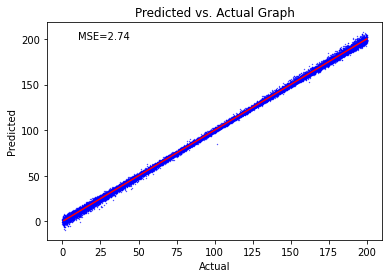

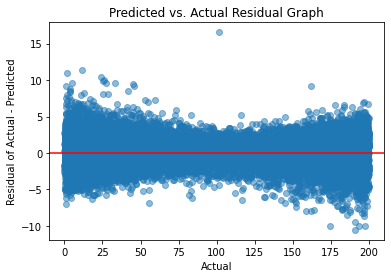

In [ ]:
res, model = train_with_CV(X, Y, Ridge, mean_squared_error, norm=False, alpha=1e-8)

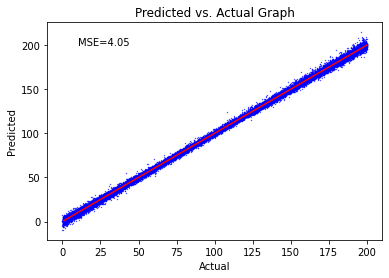

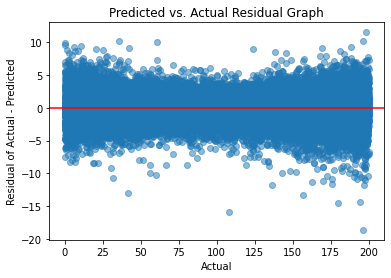

In [ ]:
res, model = train_with_CV(X[:, idx3], Y, Ridge, mean_squared_error, norm=True, alpha=1e-8)

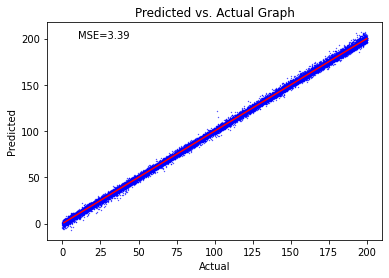

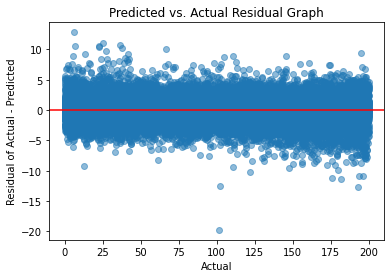

In [ ]:
res, model = train_with_CV(X[:], Y, Ridge, mean_squared_error, norm=True, alpha=1e-9)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=1.05618e-09): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=8.76653e-10): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=8.43255e-10): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=4.22849e-10): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-condit

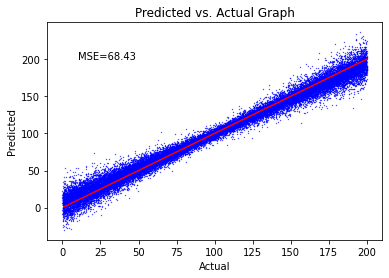

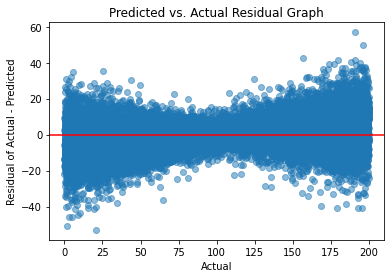

-1


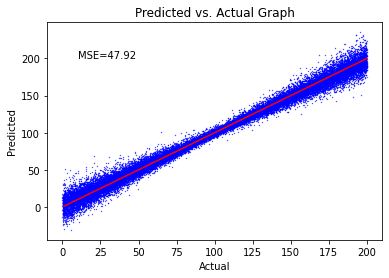

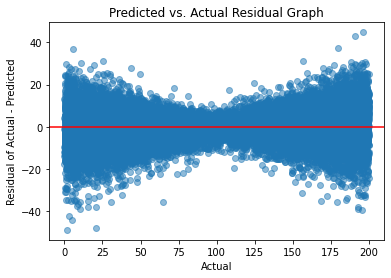

-2


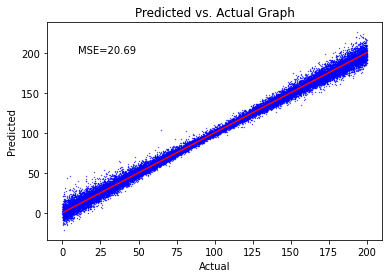

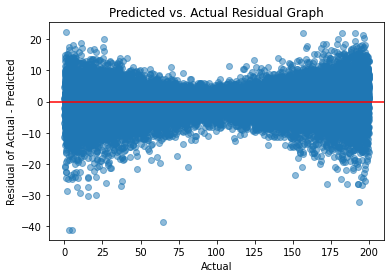

-3


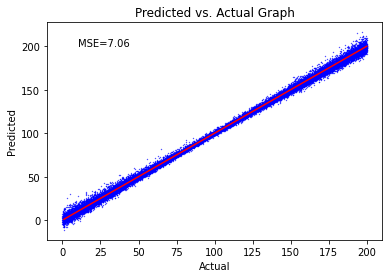

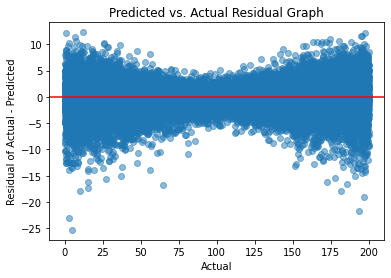

-4


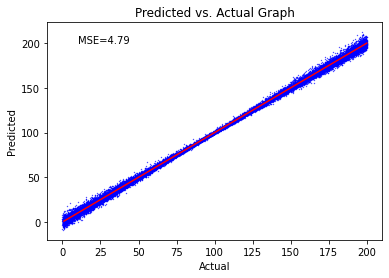

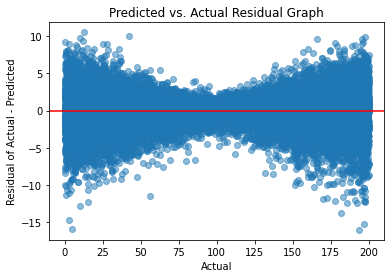

-5


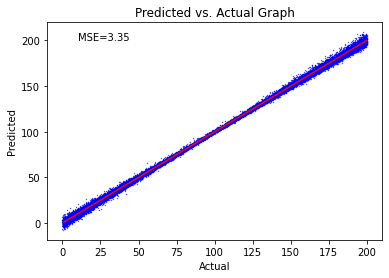

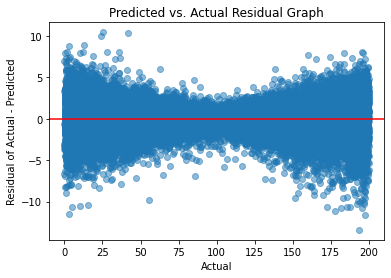

-6


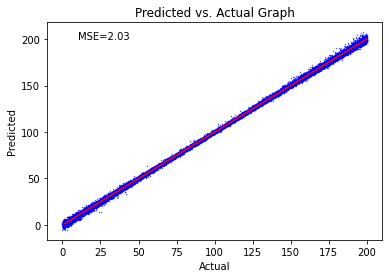

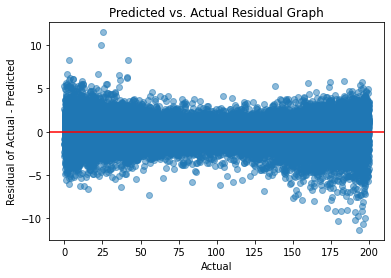

-7


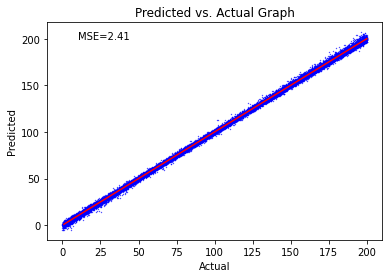

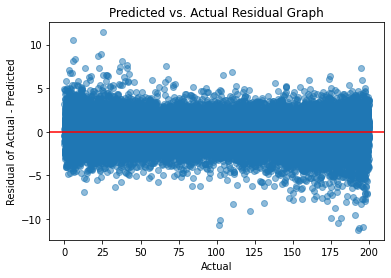

2.408052
Ridge(alpha=1e-07)
-6


In [ ]:
prev = float('inf')
exp = 0
alpha = 10**exp
curr, model = train_with_CV(X, Y, Ridge, mean_squared_error, norm=True, alpha= alpha)
final = model
final_res = curr
while curr < prev:
  final_res = curr
  final = model
  exp -= 1
  print(exp)
  prev = curr
  curr, model = train_with_CV(X, Y, Ridge, mean_squared_error, norm=True, alpha=10 ** (exp))
print(curr)
print(model)
print(exp + 1)